[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tanakat01/r-rivals/blob/main/notebooks/r-rivals.ipynb)
# アールライバルズのナッシュ戦略



## ルール
- https://www.youtube.com/watch?v=X4QCf6217Cs
に説明動画
- https://shop.game-life.jp/blog/2015/04/09/105907
にある説明を引用する．

```
道化(0)　：数値は最低だけど、カードの効果で勝負を次にもちこせます。
　　　　　 実質カードの効果を無視する魔術師以外には負けません。
　　　　　 勝てもしませんけど。
姫(1)　　：このゲームの最大のキモとなるカード。
　　　　　 このカードで相手の王子に勝てた場合、
　　　　　 その時点でゲームに勝ちます。
　　　　　 どんなに負け越していても勝ちになります。
密偵(2)　：おそらく一番使い方が難しいカード。
　　　　　 出した次の勝負は相手のカードを見てから
　　　　　 何を出すか決められます。
暗殺者(3)：このカードより弱いカードに負けて
　　　　　 強いカードに勝つ特殊なカード。
　　　　　 暗殺者で相手の将軍等の強いカードに勝てたら気持ちいいですよ！
大臣(4)　：数値的には弱くないのですが…暗殺者に負けるため、
　　　　　 実質勝てる相手が少ないです。
　　　　　 ただ、勝てた場合はその勝利は２勝分！　
　　　　　 価値ある勝利になります。
魔術師(5)：担当的には一番使いやすいカード。
　　　　　 相手の効果を無視して単純な数値のくらべ合いにもちこめます。
　　　　　 道化に勝てる唯一のカードです。
将軍(6)　：数値的に王子に次ぐ強いカード。
　　　　　 さらに次の勝負の時に出すカードの数値を＋２できる
　　　　　 強力な効果もあります。
王子(7)　：数値的に最強のカード。
　　　　　 暗殺者もよせつけないため、確実に勝ちたいときに使いましょう。
　　　　　 ただし、相手の姫には気をつけて！
```

ルールの注意点
- 道化の「勝負を持ち越す」は次に勝った人が2勝分の点を得るのか?
 - https://shop.game-life.jp/blog/2015/04/09/105907 の進行例を見るとそのとおり．
- 引き分けは?
 - 道化の直後の場合は次の勝者が1勝取るようだが，それに倣う
 - 魔術師 - 将軍 は?
  - 次のカード +2 を無効にするのか? -> そのとおり
  - 「同じターンの相手のカードの効果を無効化」
 - 片方が将軍を出した直後に魔術師 - 魔術師の場合は?
  - 将軍の効果は生きる．
 - 将軍のあとのターンで暗殺者 - 密偵(+2) は暗殺者の勝ちで良いか?
  - それはそう．
  
 





## 手番での状態
- 自分がplayer1, 相手がplayer2とする．
- それぞれのプレイヤの残りカード
 - mask1 (0 - 255), mask2 (0 - 255)
 - mask & (1 << i) ! = 0 の時に，カード i を保持
- それぞれのプレイヤの得点状況 0-3, 0-3
 - score1, score2
- next win score
 - win_score1, win_score2
 - drawが続くとwin_score1, win_score2 がともに +1
 - 大臣を出してdrawだった時は+2とする(大臣がdrawのときの効果はdrawが続く限り続くものとする)．
- 直前にどちらかだけが密偵を出したか?
 - dspy : 1の時は自分だけが密偵，-1の時は相手が密偵
- 直前に自分が密偵だった時の，相手が先に出したカード
 - prevcard :　通常は -1 , dspy が1の時は，相手が先に出したカード
- 直前に将軍
 - dgeneral 2 の時は自分がgeneral, -2 の時は相手がgeneral

これを元に 
```
((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard)
```
を状態とする．



## 両者が暗殺者 (assassin)の時
関数 next_state_sub に引数 double_assassin を追加．
- double_assassin = False (default)のときは，両者がassassinを出しても，scoreが小さい方が勝つ．
- double_assassin = True とすると，両者がassasinのときは，scoreが大きい方が勝つ．


In [11]:
init_state = ((255, 255), (0, 0), (1, 1), 0, 0, -1)
# stateが終了状態かどうか?
def is_final(state):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    return score1 >= 4 or score2 >= 4 or (mask1 == 0 and mask2 == 0)
# 終了状態のゲームスコアをplayer1の立場から返す
def final_score(state):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    if score1 >= 4:
        return 1
    elif score2 >= 4:
        return -1
    else:
        return 0
# プレイヤ1からみた状態からプレイヤ2からみた状態を作り出す．
def neg_state(state):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    return ((mask2, mask1), (score2, score1), (wscore2, wscore1), -dspy, -dgeneral, prevcard)
# maskからmoveのリストに変換
def mask2moves(mask):
    return [i for i in range(8) if (1 << i) & mask != 0]
# moveのリストからmaskに変換
def moves2mask(moves):
    ans = 0
    for x in moves:
        ans |= (1 << x)
    return ans
# stateがプレイヤ1の手番かどうか?
def canmove(state):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    if dspy == 0:
        return True
    if dspy > 0 and prevcard >= 0:
        return True
    if dspy < 0 and prevcard < 0:
        return True
    return False
def state2moves(state):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    return ((mask2moves(mask1), mask2moves(mask2)), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard)
def state2masks(state):
    ((moves1, moves2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    return ((moves2mask(moves1), moves2mask(moves2)), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard)

def next_state_sub(state, move1, move2, double_assassin=False):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    assert (mask1 & (1 << move1)) != 0
    if (mask2 & (1 << move2) == 0):
        print('state', state, 'move1', move1, 'move2', move2, 'mask2', mask2)
    assert (mask2 & (1 << move2)) != 0
    # prince and princess
    mask1 ^= 1 << move1
    mask2 ^= 1 << move2
    if move1 == 1 and move2 == 7:
        return ((mask1, mask2), (4, 0), (0, 0), 0, 0, -1)
    elif move1 == 7 and move2 == 1:
        return ((mask1, mask2), (0, 4), (0, 0), 0, 0, -1)
    str1 = move1 + dgeneral
    str2 = move2
    # wizard
    if move1 == 5 or move2 == 5:
        if str1 == str2:
            return ((mask1, mask2), (score1, score2), (wscore1 + 1, wscore2 + 1), 0, 0, -1)
        elif str1 > str2:
            return ((mask1, mask2), (score1 + wscore1, score2), (1, 1), 0, 0, -1)
        else:
            return ((mask1, mask2), (score1, score2 + wscore2), (1, 1), 0, 0, -1)
    dgeneral = (2 if move1 == 6 else 0) + (-2 if move2 == 6 else 0)
    dspy = (1 if move1 == 2 else 0) + (-1 if move2 == 2 else 0)
    wadd1 = (2 if move1 == 4 else 1)
    wadd2 = (2 if move2 == 4 else 1)
    wscore1 = wscore1 + wadd1
    wscore2 = wscore2 + wadd2
    # when each player moves assassin at the same time, the order is reversed.
    if move1 == 3 and move2 == 3 and double_assassin:
        pass
    elif (move1 == 3 and move2 != 7) or (move2 == 3 and move1 != 7): 
        str1 = -str1
        str2 = -str2
    if move1 == 0 or move2 == 0 or str1 == str2:
        return ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, -1)
    if str1 > str2:
        return ((mask1, mask2), (score1 + wscore1 - 1, score2), (1, 1), dspy, dgeneral, -1)
    else:
        return ((mask1, mask2), (score1, score2 + wscore2 - 1), (1, 1), dspy, dgeneral, -1)
# normalize
def next_state(state, move1, move2, double_assassin=False):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = next_state_sub(state, move1, move2, double_assassin)
    wscore1 = min(4 - score1, wscore1)
    wscore2 = min(4 - score2, wscore2)
    return ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard)
# spyの後
def half_move(state, move, double_assassin=False):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    assert dspy != 0
    if prevcard < 0:
        return ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, move)
    if dspy < 0:
        return next_state(state, prevcard, move, double_assassin)
    return next_state(state, move, prevcard, double_assassin)
def pp_state(state):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    return ((mask2moves(mask1), mask2moves(mask2)), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard)

## 早見表との比較
特に何もない状態でやってみて，早見表と同じ表が出ることを確認する．

|P1\P2|7|6|5|4|3|2|1|0|
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|7|△|○|○|○|○|○|■|△|
|6|×|△|○|○|×|○|○|△|
|5|×|×|△|○|○|○|○|○|
|4|×|×|×|△|×|○|○|△|
|3|×|○|×|○|△|×|×|△|
|2|×|×|×|×|○|△|○|△|
|1|◎|×|×|×|○|×|△|△|
|0|△|△|×|△|△|△|△|△|

(表の説明)
- ◎ : P1が「ゲーム」の勝ち
- ○ : P1が「勝負」に勝ち
- △ : 「勝負」は引き分け
- × : P2が「勝負」の勝ち
- ■ : P2が「ゲーム」の勝ち



In [ ]:
for i in range(7, -1, -1):
    l = ''
    for j in range(7, -1, -1):
        state = ((255, 255), (0, 0), (1, 1), 0, 0, -1)
        ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = next_state(state, i, j)
        if score1 >= 4:
            l += '◎'
        elif score1 > 0:
            l += '○'
        elif score2 >= 4:
            l += '■'
        elif score2 > 0:
            l += '×'
        else:
            l += '△'
    print(l)

## 状態数を調べる．
spyが絡まずに，各ラウンドが終わって決着がついていない時の状態の数を数える．


In [ ]:
# set all_states
def gen_all_states(double_assassin=False):
    all_states = [set()]
    all_states[-1].add(init_state)
    for i in range(8):
        nstates = set()
        magic_states = set()
        for s in all_states[-1]:
            ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
            moves1, moves2 = mask2moves(mask1), mask2moves(mask2)
            if dspy == -1:
                for move1 in moves1:
                    ns = half_move(s, move1, double_assassin)
                    magic_states.add(neg_state(ns))
                    for move2 in moves2:
                        ns1 = half_move(ns, move2, double_assassin)
                        if is_final(ns1):
                            continue
                        if ns1[3] != 1:
                            nstates.add(ns1)
                        nstates.add(neg_state(ns1))
                continue
            assert dspy == 0
            for move1 in moves1:
                for move2 in moves2:
                    ns = next_state(s, move1, move2, double_assassin)
                    if is_final(ns):
                        continue
                    if ns[3] != 1:
                        nstates.add(ns)
                    if ns[3] != -1:
                        nstates.add(neg_state(ns))
        all_states[-1] |= magic_states
        all_states.append(nstates)
    return all_states
all_states = gen_all_states()
all_states_da = gen_all_states(double_assassin=True)

In [ ]:
def print_all_states(double_assassin=False):
    print('double_assassin', double_assassin)
    for i in range(8):
        ss = all_states_da[i] if double_assassin else all_states[i]
        simul, turn1, turn2 = 0, 0, 0
        for s in ss:
            ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
            if dspy != 0:
                #assert dspy == -1
                if prevcard == -1:
                    turn1 += 1
                else:
                    turn2 += 1
            else:
                simul += 1
        print(8 - i, '&', simul, '&', turn1, '&', turn2, '\\\\')
    print(sum(len(s) for s in (all_states_da if double_assassin else all_states)))
print_all_states(False)
print_all_states(True)

## scipy.optimize.linprogの使い方
準備としてscipy.optimize.linprog
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html
を使って線形計画法の問題を解く例をみていく．
```
scipy.optimize.linprog(c, A_ub=None, b_ub=None, A_eq=None, b_eq=None, bounds=None, method='interior-point', callback=None, options=None, x0=None)
```
$$\min_{x}c^Tx$$
s.t. 
$$A_{ub} x \le b_{ub},$$
$$A_{eq} x = b_{eq},$$
$$l\le x\le u$$



In [ ]:
# sample
from scipy.optimize import linprog
c = [-1, 4]
A = [[-3, 1], [1, 2]]
b = [6, 4]
bounds =[
    (None, None),  # -∞ ≤ x ≤ ∞
    (-3, None)     # -s ≤ y ≤ ∞
]

res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='simplex')
print(res)

## Nash均衡のゲーム値の計算
### 同時出し
同時に出す場合のことを考える．
$$move1 = \{A_0, A_1, A_2, \ldots, A_{n - 1}\}$$
$$move2 = \{B_0, B_1, B_2, \ldots, B_{n - 1}\}$$
で，それぞれが$A_i, B_j$ を選択した時の，player 1 の立場からの利得の期待値を$R_{i,j}$とする．$Player_{1}$が確率$\pi = \{p_0, p_1, \ldots, p_{n - 1}\}$でそれぞれの手を選択するものとする．
確率の定義により，
$$ \sum_{i=0}^{n - 1} p_i = 1 $$
敵が$B_j$を選択した時の自分の利得は$R(j, \pi) = \sum_{i=0}^{n-1} p_i R_{i, j}$となる．相手が最善の手を選択した時の自分の利得を$v$とすると，$0 \le j \le n - 1$の$j$について，
$$v \le \sum_{i=0}^{n-1} p_i R_{i, j} $$
が成り立つ．この制約のもとで，vを最大化するという線形計画法を解く必要がある．
$$ x = (v, p_0, p_1, \ldots, p_{n - 1})^T$$
$$ c = (-1, 0, 0, \ldots, 0)^T$$
として，$c_T x$ を最小化する．
$$ \sum_{i=0}^{n - 1} p_i = 1 $$
の条件は，
$$ A_{eq} = (0, 1, 1, \ldots, 1) $$
$$ b_{eq} = 1 $$
として，
$$ A_{eq} x = b_{eq}$$
と書ける．また，
$$v \le \sum_{i=0}^{n-1} p_i R_{i, j} $$
の条件は，
$$
A_{ub} = \left(
\begin{array}{rrrrrr}
1 & -R_{0, 0} & -R_{1, 0} & \cdots & -R_{i, 0} & \cdots & -R_{n - 1, 0} \\
1 & -R_{0, 1} & -R_{1, 1} & \cdots & -R_{i, 1} & \cdots & -R_{n - 1, 1} \\
\vdots & \vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
1 & -R_{0, n - 1} & -R_{1, n - 1} & \cdots & -R_{i, n - 1} & \cdots & -R_{n - 1, n - 1} \\
\end{array}
\right)
$$
$$ b_{ub} = (0, 0, \ldots, 0)^T $$ 
として，
$$ A_{ub} x \le b_{ub}$$
とかける．





In [31]:
import scipy.optimize
import traceback
import sys
#from scipy.optimize import linprog
s2unique = {} # state でのplayer1にとっての最適解が uniqueかどうかを True, False で判定する．
def simultaneous(state, s2val, s2moves, double_assassin=False, mylinprog=scipy.optimize.linprog, debug=False):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    moves1, moves2 = mask2moves(mask1), mask2moves(mask2)
    n = len(moves1)
    c = [-1] + [0] * n
    bounds = [(None, None)] + [(0, None)] * n
    A_eq = [[0] + [1] * n]
    b_eq = [1]
    A_ub = []
    b_ub = []
    for j, move2 in enumerate(moves2):
        l = [1]
        for i, move1 in enumerate(moves1):
            l.append(-statevalue(next_state(state, move1, move2), s2val, s2moves, double_assassin, mylinprog))
        A_ub.append(l)
        b_ub.append(0)
    if debug:
        print('(A_ub, b_ub, A_eq, b_eq, bounds)', (A_ub, b_ub, A_eq, b_eq, bounds))
    res = mylinprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='simplex')
    if debug:
        print('res.x', res.x)
    moves = []
    for i, move1 in enumerate(moves1):
        moves.append((move1, res.x[i + 1]))
    s2moves[state] = moves
    return res.x[0]

def statevalue(state, s2val, s2moves, double_assassin=False, mylinprog=scipy.optimize.linprog):
    #print('statevalue: state', state)
    if is_final(state):
        return final_score(state)
    if state in s2val and state in s2moves:
        return s2val[state]
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    if dspy == 0:
        v = simultaneous(state, s2val, s2moves, double_assassin, mylinprog)
        ns = neg_state(state)
        if ns not in s2val:
            v1 = simultaneous(ns, s2val, s2moves, double_assassin, mylinprog)
            s2val[ns] = v1
    elif dspy == -1: 
        if prevcard >= 0:
            return -statevalue(neg_state(state), s2val, s2moves, double_assassin, mylinprog)
        moves1 = mask2moves(mask1)
        v, maxmove1 = -1, moves1[0]
        for move1 in moves1:
            ns = half_move(state, move1, double_assassin)
            v1 = statevalue(ns, s2val, s2moves, double_assassin, mylinprog)
            if v1 > v:
                v = v1
                maxmove1 = move1
        moves = []
        for i, move1 in enumerate(moves1):
            moves.append((move1, 1 if move1 == maxmove1 else 0))
        s2moves[state] = moves
    else:
        assert dspy == 1
        if prevcard < 0:
            return -statevalue(neg_state(state), s2val, s2moves, double_assassin, mylinprog)
        moves1 = mask2moves(mask1)
        v, maxmove1 = -1, moves1[0]
        for move1 in moves1:
            ns = half_move(state, move1, double_assassin)
            v1 = statevalue(ns, s2val, s2moves, double_assassin, mylinprog)
            if v1 > v:
                v = v1
                maxmove1 = move1
#                v = max(v, statevalue(ns, s2val, s2moves, double_assassin, mylinprog))
        moves = []
        for i, move1 in enumerate(moves1):
            moves.append((move1, 1 if move1 == maxmove1 else 0))
        s2moves[state] = moves
    s2val[state] = v
    return v
    

import json
def save_s2val(file, s2val):
    ret = []
    for state in s2val:
        ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
        v = str(s2val[state])
        ret.append([mask1, mask2, score1, score2, wscore1, wscore2, dspy, dgeneral, prevcard, v])
    s = json.dumps(ret)
    with open(file, 'wt') as wf:
        wf.write(s)

def load_s2val(file, str2num=float):
    s2val = {}
    with open(file, 'rt') as rf:
        s = json.load(rf)
    for mask1, mask2, score1, score2, wscore1, wscore2, dspy, dgeneral, prevcard, v in s:
        s2val[((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard)] = str2num(v)
    return s2val
def save_s2moves(file, s2moves):
    ret = []
    for state in s2moves:
        ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
        vs = []
        for m, p in s2moves[state]:
            vs.append([m, str(p)])
        ret.append([mask1, mask2, score1, score2, wscore1, wscore2, dspy, dgeneral, prevcard, vs])
    with open(file, 'wt') as wf:
        json.dump(ret, wf)
def load_s2moves(file, str2num=float):
    s2moves = {}
    with open(file, 'rt') as rf:
        s = json.load(rf)
    for mask1, mask2, score1, score2, wscore1, wscore2, dspy, dgeneral, prevcard, vs in s:
        s2moves[((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard)] = [[x[0], str2num(x[1])] for x in vs]
    return s2moves
  


## 厳密解の計算

線形計画法の厳密解ソルバとして有名なものは，として QSOpt_ex , SoPlex などがあるが，本研究では　Dmitry Shintyakov 氏が作成したPython言語のみで書かれた Simplex 法プログラムhttps://github.com/dmishin/pylinprog を使用する．


In [ ]:
!curl -O https://raw.githubusercontent.com/dmishin/pylinprog/master/linprog.py

In [ ]:
from fractions import Fraction
from linprog import linsolve
from linprog import RationalNumbers
from linprog import simplex_canonical_m
def toFrac(x):
    if x is None or isinstance(x, Fraction):
        return x
    return Fraction(x)
class linres:
    def __init__(self, x):
        self.x = x

def exact_linprog(C, A_eq, b_eq, A_ub, b_ub, bounds, method='simplex',callback=None,options=None):
    nonneg_variables = []
    for i, (low, high) in enumerate(bounds):
        if low == 0:
            nonneg_variables.append(i)
    num = RationalNumbers()
    print('nonneg_variables', nonneg_variables)
    resolution, sol = linsolve(C, ineq_left=A_ub, ineq_right=b_ub, eq_left=A_eq, eq_right=b_eq, 
                               nonneg_variables = nonneg_variables, num=num)
    return linres(sol)

## 計算と保存
計算した結果だけを使うならば，後の「公開データのダウンロードとロード」まで飛ばしてください．

In [ ]:
# s2val, s2movesの計算と保存
s2val = {}
s2moves = {}
statevalue(init_state, s2val, s2moves)
save_s2val('s2val.txt', s2val)
save_s2moves('s2moves.txt', s2moves)

In [ ]:
# s2val_da, s2moves_daの計算と保存
s2val_da = {}
s2moves_da = {}
statevalue(init_state, s2val_da, s2moves_da, double_assassin=True)
save_s2val('s2val_da.txt', s2val_da)
save_s2moves('s2moves_da.txt', s2moves_da)

In [ ]:
# s2val_exact, s2moves_exactの計算と保存
s2val_exact = {}
s2moves_exact = {}
statevalue(init_state, s2val_exact, s2moves_exact, mylinprog=exact_linprog)
save_s2val('s2val_exact.txt', s2val_exact)
save_s2moves('s2moves_exact.txt', s2moves_exact)

In [ ]:
# s2val_da_exact, s2moves_da_exactの計算と保存
s2val_da_exact = {}
s2moves_da_exact = {}
statevalue(init_state, s2val_da_exact, s2moves_da_exact, double_assassin=True, mylinprog=exact_linprog)
save_s2val('s2val_da_exact.txt', s2val_da_exact)
save_s2moves('s2moves_da_exact.txt', s2moves_da_exact)

## 検証
厳密解 s2val と通常解 s2val_exact で大きな差がないかどうかの検証をおこなう．

In [ ]:
# 厳密解と通常解との差がないかどうかの検証
for k in s2val:
    if abs(s2val[k] - s2val_exact[k]) > 1e-8:
        print('k, s2val, s2val_exact', (k, s2val[k], s2val_exact[k]))

In [6]:
# 厳密解と通常解との差がないかどうかの検証
for k in s2val_da:
    if abs(s2val_da[k] - s2val_da_exact[k]) > 1e-8:
        print('k, s2val_da, s2val_da_exact', (k, s2val_da[k], s2val_da_exact[k]))

NameError: ignored

## 公開データのダウンロードとロード



In [17]:
!curl -O https://raw.githubusercontent.com/tanakat01/r-rivals/main/data/s2val.txt
!curl -O https://raw.githubusercontent.com/tanakat01/r-rivals/main/data/s2moves.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.2M  100 22.2M    0     0  19.3M      0  0:00:01  0:00:01 --:--:-- 19.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41.8M  100 41.8M    0     0  26.3M      0  0:00:01  0:00:01 --:--:-- 26.3M


In [18]:
!head s2val.txt

Output hidden; open in https://colab.research.google.com to view.

In [19]:
s2val = load_s2val('s2val.txt')
s2moves = load_s2moves('s2moves.txt')

In [ ]:
!curl -O https://raw.githubusercontent.com/tanakat01/r-rivals/main/data/s2val_da.txt
!curl -O https://raw.githubusercontent.com/tanakat01/r-rivals/main/data/s2moves_da.txt

In [ ]:
s2val_da = load_s2val('s2val_da.txt')
s2moves_da = load_s2moves('s2moves_da.txt')

In [25]:
!curl -O https://raw.githubusercontent.com/tanakat01/r-rivals/main/data/s2val_exact.txt
!curl -O https://raw.githubusercontent.com/tanakat01/r-rivals/main/data/s2moves_exact.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.2M  100 20.2M    0     0  46.6M      0 --:--:-- --:--:-- --:--:-- 46.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38.1M  100 38.1M    0     0  54.8M      0 --:--:-- --:--:-- --:--:-- 54.8M


In [27]:
!ls -al s2moves_exact.txt

-rw-r--r-- 1 root root 39990028 Nov  3 04:49 s2moves_exact.txt


In [32]:
from fractions import Fraction
s2val_exact = load_s2val('s2val_exact.txt', str2num=Fraction)
s2moves_exact = load_s2moves('s2moves_exact.txt', str2num=Fraction)

In [34]:
!curl -O https://raw.githubusercontent.com/tanakat01/r-rivals/main/data/s2val_da_exact.txt
!curl -O https://raw.githubusercontent.com/tanakat01/r-rivals/main/data/s2moves_da_exact.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.2M  100 20.2M    0     0  21.5M      0 --:--:-- --:--:-- --:--:-- 21.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38.1M  100 38.1M    0     0  33.1M      0  0:00:01  0:00:01 --:--:-- 33.1M


In [35]:
from fractions import Fraction
s2val_da_exact = load_s2val('s2val_da_exact.txt', str2num=Fraction)
s2moves_da_exact = load_s2moves('s2moves_da_exact.txt', str2num=Fraction)

# 値の分布
pandasを使ってヒストグラムを作成する．

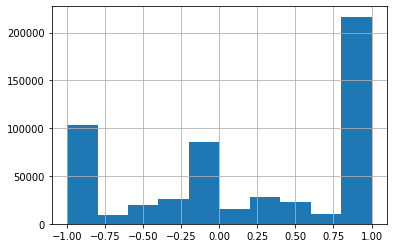

In [36]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plot
s = pd.Series(list(s2val.values()))
s.hist()
    


## 初期局面での戦略
まずは，初期局面でのナッシュ均衡戦略を表示する．
```
s2val[init_state]
```
は，ゲームの対称性から0になるはずである．実際に求めてみると，
```
8.782536712126523e-17
```
とほぼ0になっていることがわかる．


In [37]:
s2val[init_state]

2.487244302333875e-16

初期状態の利得行列を表示する．

In [38]:
def print_return_matrix(state, double_assassin=False):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    moves1, moves2 = mask2moves(mask1), mask2moves(mask2)
    n = len(moves1)
    print('P1＼P2', end='')
    for j, m2 in enumerate(moves2):
        print('&', m2, end='')
    print('\\\\')
    def roundstr(v):
        if abs(v) < 1e-7:
            return '0'
        elif abs(v - 1) < 1e-7:
            return '1'
        elif abs(v + 1) < 1e-7:
            return '-1'
        return f'{v:0.5f}'
    for i, m1 in enumerate(moves1):
        print(m1, end='')
        for j, m2 in enumerate(moves2):
            ns = next_state(state, m1, m2, double_assassin)
            v = statevalue(ns, s2val_da if double_assassin else s2val, s2moves_da if double_assassin else s2moves, double_assassin)
            print(f' & {roundstr(v)}',end='')
        print('\\\\')



In [39]:
print_return_matrix(init_state)

P1＼P2& 0& 1& 2& 3& 4& 5& 6& 7\\
0 & 0 & -0.01177 & -0.49893 & 0.04516 & -0.10607 & 0.00193 & 0.07208 & 0.35812\\
1 & 0.01177 & 0 & -0.49910 & 0.32692 & -0.61282 & -0.01548 & 0.01164 & 1\\
2 & 0.49893 & 0.49910 & 0 & 0.31530 & -0.42120 & -0.01222 & 0.01580 & 0.28045\\
3 & -0.04516 & -0.32692 & -0.31530 & 0 & 0.31017 & -0.01332 & 0.36280 & 0.05922\\
4 & 0.10607 & 0.61282 & 0.42120 & -0.31017 & 0 & -0.02830 & -0.05954 & -0.05382\\
5 & -0.00193 & 0.01548 & 0.01222 & 0.01332 & 0.02830 & 0 & -0.26833 & -0.28208\\
6 & -0.07208 & -0.01164 & -0.01580 & -0.36280 & 0.05954 & 0.26833 & 0 & -0.23217\\
7 & -0.35812 & -1 & -0.28045 & -0.05922 & 0.05382 & 0.28208 & 0.23217 & 0\\


次に，ナッシュ均衡戦略で，どのアクションをどの確率でどの確率で生成するかを表示する．
```
s2moves[init_state]
```
の実行結果は
```
[[0, 0.0],
 [1, 0.0],
 [2, 0.22175583508357324],
 [3, 0.2719122699143252],
 [4, 0.22684759633778984],
 [5, 0.23428083687676557],
 [6, 0.0],
 [7, 0.0452034617875461]]
 ```
 となるので，
* 「道化(0)」，「姫(1)」，「将軍(6)」は出さない
* スパイ(2)は確率 0.22175583508357324 で出す
* 暗殺者(3)は確率 0.2719122699143252 で出す
* 大臣(4)は確率 0.22684759633778984 で出す
* 魔術師(5)は確率 0.23428083687676557 で出す
* 王子(7)は確率 0.0452034617875461 で出す
で出す戦略が，ナッシュ均衡戦略であることがわかる．

なお，2人零和ゲームの性質により，ナッシュ均衡でのゲーム値の一意性は保証されるが，戦略には複数のナッシュ均衡があり得るので，もう少し詳しく検証する．

まず，「道化(0)」，「姫(1)」，「将軍(6)」を出したときの，相手が上記の戦略を採用したときの，期待値を求める．



In [40]:
s2moves[init_state]

[[0, 0.0],
 [1, 0.0],
 [2, 0.22175583508357463],
 [3, 0.27191226991432327],
 [4, 0.2268475963377912],
 [5, 0.23428083687675866],
 [6, 0.0],
 [7, 0.04520346178754673]]

In [41]:
# 同時のみ
def val_against_nash(state,s2val,s2moves):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    moves1 = mask2moves(mask1)
    allans = []
    for move1 in moves1:
        ans = 0
        ret = []
        for move2, p in s2moves[neg_state(state)]:
            ns = next_state(state, move1, move2)
            v = statevalue(ns,s2val, s2moves)
            ans += p * v
            ret.append([move2, v])
        print('move1', move1, 'ans', ans, 'ret', ret)
        allans.append((move1, ans))
    return allans




In [42]:
val_against_nash(init_state,s2val, s2moves)

move1 0 ans -0.10578205993526141 ret [[0, 3.1737181059431603e-15], [1, -0.011765326997635144], [2, -0.4989261743589231], [3, 0.04516274437272096], [4, -0.10607340042012017], [5, 0.001927837397393124], [6, 0.07207899372390306], [7, 0.3581200662185647]]
move1 1 ans -0.11922403397700951 ret [[0, 0.011765326997637035], [1, -1.734723475976807e-17], [2, -0.499096385816779], [3, 0.3269230034121602], [4, -0.6128211999103577], [5, -0.015482784462535683], [6, 0.011641276082876299], [7, 1]]
move1 2 ans 1.0044048925905713e-15 ret [[0, 0.4989261743589231], [1, 0.499096385816779], [2, 6.591638635975241e-16], [3, 0.315296012835419], [4, -0.42119536429193916], [5, -0.012219920875640545], [6, 0.01580147673366661], [7, 0.2804474308212942]]
move1 3 ans -8.140189911021167e-16 ret [[0, -0.04516274437272301], [1, -0.32692300341216046], [2, -0.315296012835419], [3, -5.169475958410885e-16], [4, 0.3101716496104876], [5, -0.01331738073197868], [6, 0.3627970869335558], [7, 0.05922211387368431]]
move1 4 ans 1.533

[(0, -0.10578205993526141),
 (1, -0.11922403397700951),
 (2, 1.0044048925905713e-15),
 (3, -8.140189911021167e-16),
 (4, 1.5330618718945033e-15),
 (5, -9.8879238130678e-17),
 (6, -0.03627463406470905),
 (7, -2.305138849476512e-15)]

結果は，
```
[(0, -0.1057820599352605),
 (1, -0.11922403397700802),
 (2, 1.708702623837155e-15),
 (3, -1.0568802777388697e-15),
 (4, -6.92154666914746e-16),
 (5, -7.441963711940502e-16),
 (6, -0.036274634064723046),
 (7, 1.6958638798894469e-16)]
```
なので，勝ちを1，負けを-1, 引き分けを0として，道化，姫，将軍を出すと期待値が，

* 道化(0) -0.1057820599352605
* 姫(1) -0.11922403397700802
* 将軍(6) -0.036274634064723046

と，ナッシュ均衡での利得0を下回ることがわかる．



## ナッシュ均衡戦略同士の対戦結果
求まったナッシュ均衡戦略同士の対戦結果を解析する．
まずは，各stateの到達確率を求める．

In [43]:
def addprob(state, v, probs, s2moves):
    if state not in s2moves:
        ns = neg_state(state)
        probs[ns] = probs.get(ns, 0) + v
    else:
        probs[state] = probs.get(state, 0) + v


def propagate_prob(state, s2moves, probs, double_assassin=False):
    if is_final(state):
        return
    if state not in probs:
        return
    p = probs[state]
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    negs = neg_state(state)
    if dspy == 0:
        v = 0
        for m1, p1 in s2moves[state]:
            for m2, p2 in s2moves[negs]:
                ns = next_state(state, m1, m2, double_assassin)
                addprob(ns, p * p1 * p2, probs, s2moves)
    elif dspy == -1:
        assert prevcard < 0
        for m1, p1 in s2moves[state]:
            ns = half_move(state, m1, double_assassin)
            addprob(ns, p * p1, probs, s2moves)
    else:
        assert dspy == 1
        assert prevcard >= 0
        for m1, p1 in s2moves[state]:
            ns = half_move(state, m1, double_assassin)
            addprob(ns, p * p1, probs, s2moves)

In [44]:
probs = {}
probs[init_state] = 1
for level_states in all_states:
    for s in level_states:
        if s[5] < 0:
            propagate_prob(s, s2moves, probs)
    for s in level_states:
        if s[5] >= 0:
            propagate_prob(s, s2moves, probs)


NameError: ignored

In [ ]:
# ただしそうか?
for i, level_states in enumerate(all_states):
    psum = 0
    for s in level_states:
        if s[5] < 0:
            psum += probs.get(s, 0)
    psum1 = 0
    for s in level_states:
        if s[5] >= 0:
            psum1 += probs.get(s, 0)
    print(i, psum, psum1)

In [ ]:
# 各ターンで出すカードの確率
cprob = [[0] * 8 for _ in range(8)]
for i, level_states in enumerate(all_states):
    for s in level_states:
        if s[5] < 0:
            p = probs.get(s, 0)
            if s[3] != 0:
                p *= 0.5
            for m, p1 in s2moves[s]:
                cprob[i][m] += p * p1
    for s in level_states:
         if s[5] >= 0:
            p = probs.get(s, 0) * 0.5
            for m, p1 in s2moves[s]:
                cprob[i][m] += p * p1
print('cards＼turn &', ' & '.join(str(x) for x in range(1, 9)), ' & not used \\\\')
for c in range(8):
    print(c, end='')
    for j in range(8):
        print(f' & {cprob[j][c]:.5f}', end='')
    notused = 1 - sum(cprob[j][c] for j in range(8))
    print(f' & {notused:.5f} \\\\')
print('SUM', end='')
for j in range(8):
    print(f' & {sum(cprob[j]):.5f}', end='')
print(' & \\\\')

In [ ]:
fs = [0] * 3
for s in probs:
    if is_final(s):
        i = final_score(s)
        fs[i + 1] += probs[s]
print(fs)        

In [ ]:
print(sum(fs))

# ランダムプレイヤ相手の利得
まずは，プレイヤ0がsts[0], プレイヤ1が sts[1] の時のプレイヤ1の利得を求める．

In [ ]:
s2random_moves = {}
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    moves = mask2moves(mask1)
    n = len(moves)
    ms = [(move, 1/n) for move in moves]
    s2random_moves[s] = ms


In [ ]:
from typing import List
def state_p2_value(state, turn, sts, ps2val, double_assassin=False):
    if is_final(state):
        return final_score(state)
    if (turn, state) in ps2val:
        return ps2val[(turn, state)]
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    negs = neg_state(state)
    if dspy == 0:
        v = 0
        for m1, p1 in sts[turn][state]:
            for m2, p2 in sts[1 - turn][negs]:
                ns = next_state(state, m1, m2, double_assassin)
                v += p1 * p2 * state_p2_value(ns, turn, sts, ps2val, double_assassin)
    elif dspy == -1:
        if prevcard >= 0:
            return -state_p2_value(negs, 1 - turn, sts, ps2val, double_assassin)
        v = 0
        psum = 0
        for m1, p1 in sts[turn][state]:
            psum += p1
            ns = half_move(state, m1, double_assassin)
            v += p1 * state_p2_value(ns, turn, sts, ps2val, double_assassin)
        assert abs(psum - 1) < 1e-5
    else:
        assert dspy == 1
        if prevcard < 0:
            return -state_p2_value(negs, 1 - turn, sts, ps2val, double_assassin)
        v = 0
        psum = 0
        for m1, p1 in sts[turn][state]:
            psum += p1
            ns = half_move(state, m1, double_assassin)
            v += p1 * state_p2_value(ns, turn, sts, ps2val, double_assassin)
        assert abs(psum - 1) < 1e-5
    ps2val[(turn, state)] = v
    return v






In [ ]:
ps2val = {}
against_random = state_p2_value(init_state, 0, (s2moves, s2random_moves), ps2val)
print(against_random)

In [ ]:
ps2val = {}
against_self = state_p2_value(init_state, 0, (s2moves, s2moves), ps2val)
print(against_self)

## deterministic moves


In [ ]:
s2det_moves = {}
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    for m, v in s2moves[s]:
        if abs(v) > 1e-5:
            s2det_moves[s] = [(m, 1.0)]
            break


In [ ]:
ps2val = {}
against_det = state_p2_value(init_state, 0, (s2moves, s2det_moves), ps2val)
print(against_det)

# 負ける王子は出さないが他はランダム


In [ ]:
s2noprince_moves = {}
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    moves = mask2moves(mask1)
    if 7 in moves and len(moves) > 1 and (prevcard == 1 or (prevcard == -1 and dspy == -1 and (mask2 & (1 << 1)) != 0)):
        moves.remove(7)
    n = len(moves)
    ms = [(move, 1/n) for move in moves]
    s2noprince_moves[s] = ms


In [ ]:
i = 0
for s in s2noprince_moves:
    psum = 0
    for m, p in s2noprince_moves[s]:
        psum += p
    if abs(psum - 1) > 1e-5:
        print(s, s2noprince_moves[s])


In [ ]:
ps2val = {}
against_noprince = state_p2_value(init_state, 0, (s2moves, s2noprince_moves), ps2val)
print(against_noprince)

In [ ]:
ps2val1 = {}
against_random = state_p2_value(init_state, 0, (s2moves, s2random_moves), ps2val1)
print(against_random)
ps2val2 = {}
against_noprince = state_p2_value(init_state, 0, (s2moves, s2noprince_moves), ps2val2)
print(against_noprince)
i = 0
for s in ps2val1:
    if s in ps2val2 and abs(ps2val1[s] - ps2val2[s]) > 1e-5:
        print(s)
        i += 1
        if i > 100:
            break

In [ ]:
print(len(ps2val1))
print(len(ps2val2))


In [ ]:
state2moves(((242, 124), (2, 1), (1, 1), 0, 0, -1))

# 残り枚数ごとの勝ち確定

## 残り枚数2の最善手の確認
残り枚数が2で，valが0でも1でもない例を10個表示

In [ ]:
EPS = 1e-3
k = 0
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    i = len(mask2moves(mask1))   
    if i == 2 and abs(-1 - s2val[s]) > EPS and  abs(1 - s2val[s]) > EPS and(s2val[s]) > EPS:
        print(s2val[s], s2moves[s], ((mask2moves(mask1), mask2moves(mask2)), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard))
        k += 1
        if k > 10:
            break

(([2, 5], [2, 3]), (3, 3), (1, 1), 0, -2, -1)
を掘り下げる． 両方とも3点なので，あと1点で勝ち．　相手は次の勝負は将軍補正がかかっている．

密偵(2)　：おそらく一番使い方が難しいカード。
　　　　　 出した次の勝負は相手のカードを見てから
　　　　　 何を出すか決められます。
暗殺者(3)：このカードより弱いカードに負けて
　　　　　 強いカードに勝つ特殊なカード。
　　　　　 暗殺者で相手の将軍等の強いカードに勝てたら気持ちいいですよ！
魔術師(5)：担当的には一番使いやすいカード。
　　　　　 相手の効果を無視して単純な数値のくらべ合いにもちこめます。
　　　　　 道化に勝てる唯一のカードです。


* 自分が魔術師(5)を出して，相手は暗殺者(3)
 - 相手の暗殺者の効果はキャンセルされる．
 - 将軍補正はキャンセルされない(説明書の将軍の説明で「ただし，次のカードが魔術師と勝負する場合は，この効果は有効です」とある)
 - 点数5, 5 で引き分け，次も密偵，密偵で引き分けなので，0
* 自分が魔術師(5)を出して，相手は密偵(2)
 - 点数5,4で先手勝ち
* 自分が密偵(2)を出して，相手は暗殺者(3)
 - 点数 2,5 だが， 暗殺者によって強さが逆転するので先手勝ち
* 自分が密偵(2)を出して，相手は密偵(2)
 - 点数 2, 4 で相手の勝ち

自分が魔術師を2/3, 密偵を1/3で出すとする．
- 相手が暗殺者を出すと 2/3の確率で引き分け，1/3の確率で先手勝ち (利得の期待値 1/3)
- 相手が密偵を出すと 2/3の確率で先手勝ち， 1/3の確率で後手勝ち (利得の期待値 1/3)
 
 

In [ ]:
state2 = (((1<<2)+(1<<5),(1<<2)+(1<<3)), (3, 3), (1, 1), 0, -2, -1)
state1 =next_state(state2, 5, 3)
print(state1)
print(s2val[state1])

## 残り枚数2で勝負が決まっている例．
残り枚数が2で，valが1


In [ ]:
EPS = 1e-3
k = 0
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    i = len(mask2moves(mask1))   
    if i == 2 and abs(1 - s2val[s]) <= EPS:
        print(s2val[s], s2moves[s], ((mask2moves(mask1), mask2moves(mask2)), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard))
        k += 1
        if k > 10:
            break

まずは，正解が一つの例
(([6, 7], [4, 7]), (3, 3), (1, 1), 0, 0, -1)
両方が3点, 次に勝った方が勝ち(4点以上取る手は意味がないとして，正規化しているので (1,1)となる)
[将軍，王子] vs [大臣，王子]
* 自分が王子，相手が王子
 - 引き分けで，次に将軍が大臣に勝って勝ち
* 自分が王子，相手が大臣
 - このターンで勝ち
* 自分が将軍相手が王子
- このターンで負け
* 自分が将軍，相手が大臣
 - このターンで勝ち
 
 自分が王子を出すと確実に勝てるが，大臣を出すと相手が王子を出したら負ける
 
どちらでも正解の例
(([6, 7], [4, 6]), (3, 3), (1, 1), 0, 0, -1)
[将軍，王子] vs [大臣，将軍]
- 自分が王子を出すとそのターンで勝ち
- 自分が将軍を出すと，相手が大臣ならそのターンで勝ち，相手が将軍だとそのターンは引き分け次のターンで王子，大臣で勝ち





# 現在の得点と必勝，必敗


In [ ]:
wl = [[[0] * 3 for _ in range(4)] for _ in range(4)]
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    if dspy != 0:
        continue
    v = s2val[s]
    if abs(v - 1) < 1e-5:
        wl[score1][score2][0] += 1
    elif abs(v + 1) < 1e-5:
        wl[score1][score2][2] += 1
    else:
        wl[score1][score2][1] += 1
for i in range(4):
    print(i, '&', end='')
    for j in range(4):
        print(tuple(wl[i][j]), '&', end='')
    print('\\\\')


In [ ]:
wl = [[[0] * 3 for _ in range(4)] for _ in range(4)]
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    if dspy == 0:
        continue
    v = s2val[s]
    if abs(v - 1) < 1e-5:
        wl[score1][score2][0] += 1
    elif abs(v + 1) < 1e-5:
        wl[score1][score2][2] += 1
    else:
        wl[score1][score2][1] += 1
for i in range(4):
    print(i, '&', end='')
    for j in range(4):
        print(tuple(wl[i][j]), '&', end='')
    print('\\\\')

In [ ]:
ans = []
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    if dspy != 0:
        continue
    if score1 == 0 and score2 == 3 and abs(s2val[s] - 1) < 1e-5:
        ans.append(s)
print([state2moves(x) for x in ans[:10]])

## 大逆転パターン
(0,  3) の不利だが，残り札の関係で確実に勝てる例
残り枚数が多いごとにprint
ただし，前のターンで密偵を出して，自分に姫(1)が残っているのに相手が王子(7)を出すというパターンは除く．


In [ ]:
EPS = 1e-3
k = 0
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    if score1 == 0 and score2 == 3 and abs(1 - s2val[s]) < EPS:
        move1 = mask2moves(mask1)
        if len(move1) > k and prevcard != 7:
            print(s2val[s], ((mask2moves(mask1), mask2moves(mask2)), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard))
            k = len(move1)


1.0 (([3, 4, 5, 6, 7], [1, 2, 3, 4, 6]), (0, 3), (1, 1), 1, 0, 3)
というパターンが見つかる．
相手の暗殺者(3)に対して王子(7)を出す．これは勝ちで次の状態は
(([3,4,5,6], [1,2,4,6]),(1,3),(1,1),0,0,-1)



In [ ]:
s = ((moves2mask([3, 4, 5, 6, 7]), moves2mask([1, 2, 3, 4, 6])), (0, 3), (1, 1), 1, 0, 3)
print('s2moves', s2moves[s])

In [ ]:
s = ((moves2mask([3, 4, 5, 6, 7]), moves2mask([1, 2, 3, 4, 6])), (0, 3), (1, 1), 1, 0, 3)
s2 = half_move(s, 7)
print('s2val', s2val[s2], 's2moves', s2moves[s2])

In [ ]:
(([3,4,5,6], [1,2,4,6]),(1,3),(1,1),0,0,-1)
で，将軍(6)を出す．
- 相手が将軍(6)
 - 引き分けで，次は(([3,4,5], [1,2,4]),(1,3),(2,2),0,0,-1)
- 相手が大臣(4)
 - 勝って，次は (([3,4,5], [1,2,6]),(1,2),0,-2,-1)
- 相手が密偵(2)
 - 勝って，次は(([3,4,5],[1,4,6],(1,1),-1,0,-1))
- 相手が姫(1)
 - 勝って次は(([3,4,5],[2,4,6],(1,1),0,0,-1))
    


In [ ]:
s = ((moves2mask([3,4,5,6]), moves2mask([1,2,4,6])),(1,3),(1,1),0,0,-1)
for m2 in mask2moves(s[0][1]):
    ns = next_state(s, 6, m2)
    print('m', m2, 's2moves[ns]', s2moves[ns], 's2val[ns]', s2val[ns], 'ns', ns)
    

In [ ]:
ターンの最初のパターンのみを探す．


In [ ]:
EPS = 1e-3
k = 0
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    if score1 == 0 and score2 == 3 and abs(1 - s2val[s]) < EPS:
        move1 = mask2moves(mask1)
        if len(move1) > k and prevcard == -1:
            print(s2val[s], ((mask2moves(mask1), mask2moves(mask2)), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard))
            k = len(move1)


In [ ]:
EPS = 1e-3
ans = []
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    if (score1 + wscore1) == 1 and score2 == 3 and abs(1 - s2val[s]) < EPS and (prevcard != 7 or (mask1 & (1 << 1)) == 0):
        move1 = mask2moves(mask1)
        ans.append(s)
print(len(ans))

In [ ]:
print(list(state2moves(x) for x in ans[:10]))

In [ ]:
state = state2masks((([3, 4, 5, 6, 7], [1, 2, 3, 4, 6]), (0, 3), (1, 1), 1, 0, 3))
print(s2moves[state])
state1 = state2masks((([3, 4, 5, 6], [1, 2, 4, 6]), (1, 3), (1, 1), 0, 0, -1))
print(state1, s2moves[state1])
state2 = state2masks((([3, 4, 5], [1, 2, 4]), (1, 3), (2, 1), 0, 0, -1))
print(state2, s2val[state2], s2moves[state2])

In [ ]:
EPS = 1e-3
k = 0
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    if (score1 + wscore1) == 2 and score2 == 3 and abs(1 - s2val[s]) < EPS and prevcard == -1:
        move1 = mask2moves(mask1)
        print(s2val[s], ((mask2moves(mask1), mask2moves(mask2)), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard))


今度は残り枚数が4枚のパターンしか見つからなかった．残り4枚のパターンは?



In [ ]:
EPS = 1e-3
ans = []
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    if score1 == 0 and score2 == 3 and abs(1 - s2val[s]) < EPS:
        move1 = mask2moves(mask1)
        if len(move1) ==4 and prevcard == -1:
            ans.append(s)
print(len(ans), ans[:5])

In [ ]:
次に勝っても自分は1のパターンは? 
prevcard == -1 ではなし

In [ ]:
EPS = 1e-3
ans = []
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    if score1 == 0 and score2 == 3 and abs(1 - s2val[s]) < EPS:
        move1 = mask2moves(mask1)
        if wscore1 == 1and prevcard == -1:
            ans.append(s)
print(len(ans), ans[:5])

In [ ]:
prevcard != 7 

In [ ]:
EPS = 1e-3
ans = []
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    if score1 == 0 and score2 == 3 and abs(1 - s2val[s]) < EPS:
        move1 = mask2moves(mask1)
        if wscore1 == 1and prevcard != 7:
            ans.append(s)
print(len(ans), list(state2moves(x) for x in ans[:5]))

In [ ]:
print(s2moves[init_state])

In [ ]:
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    if len(mask2moves(mask1)) == 6 and (score2 == 3 or score1 == 3):
        print(s2val[s], ((mask2moves(mask1), mask2moves(mask2)), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard))
       

In [ ]:
state2 = ((184, 108), (0, 3), (2, 1), 1, 0, 2)
((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state2
print(s2val[state2])
print(((mask2moves(mask1), mask2moves(mask2)), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard))


In [ ]:
state2 = ((184, 108), (0, 3), (2, 1), 1, 0, 2)
for m in mask2moves(state2[0][0]):
    state3 = half_move(state2, m)
    print('m', m, 'v', statevalue(state3))

(([3, 4, 5, 7], [2, 3, 5, 6]), (0, 3), (2, 1), 1, 0, 2)
自分が前のターンでスパイを出して，相手がスパイを出したところ．自分はこのターンで勝つと2ポイント手に入る．
大臣(4)を出すと，次は
(([3, 5, 7], [3, 5, 6]), (3, 3), (1, 1), -1, 0, -1)
ここで，自分から出さなくてはいけないが，王子(7) を出すと相手が暗殺者(3), 魔術師(5), 将軍(6)のどれを出しても勝つ(暗殺者は王子相手には効果がない)．





In [ ]:
# 残り枚数ごとの勝ち確定
win_by_cards = [[] for _ in range(9)]
for s in s2val:
    i = len(mask2moves(s[0][0]))
    if statevalue(s) + 1e-5 > 1:
        win_by_cards[i].append(s)
print([len(x) for x in win_by_cards])        

In [ ]:
for s in win_by_cards[7]:
    print(pp_state(s))

In [ ]:
(([0, 1, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7]), (0, 0), (2, 2), 1, 0, 7)
(([0, 1, 3, 4, 5, 6, 7], [0, 2, 3, 4, 5, 6, 7]), (1, 0), (1, 1), 1, 0, 7)
(([0, 1, 3, 4, 5, 6, 7], [0, 1, 2, 4, 5, 6, 7]), (1, 0), (1, 1), 1, 0, 7)
(([0, 1, 3, 4, 5, 6, 7], [0, 1, 2, 3, 5, 6, 7]), (0, 2), (1, 1), 1, 0, 7)
(([0, 1, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 7]), (0, 1), (1, 1), 1, -2, 7)
「こちらが，密偵(2)を出した次のターンで相手が王子を出したパターン」

In [ ]:
# 残り枚数ごとの勝ち確定
win_sim_by_cards = [[] for _ in range(9)]
for s in s2val:
    if s[3] != 0:
        continue
    i = len(mask2moves(s[0][0]))
    if statevalue(s) + 1e-5 > 1:
        win_sim_by_cards[i].append(s)
print([len(x) for x in win_sim_by_cards])        

In [ ]:
for s in win_sim_by_cards[6]:
    print(pp_state(s))
    print(s2moves[s])

```
(([0, 1, 2, 3, 5, 7], [2, 3, 4, 5, 6, 7]), (3, 0), (1, 1), 0, 2, -1)
```
大臣(4), 将軍(6) に対して相手が道化(0), 姫(1) を出し，(3, 0)とリード
3　次の手は魔術師(+2としているので強さは7) 相手が2,3,4,5,6 ならば強さで勝てる(暗殺者は無効)．相手が7の時には引き分けとなり，次の状態は (([0, 1, 2, 3, 7], [2, 3, 4, 5, 6]), (3, 0), (1, 2), 0, 0, -1)
4. ここで道化を出す．相手が将軍(6)を出した時は，ターン5で暗殺者を出して勝ち．それ以外では，王子を出して勝ち．
```
(([0, 1, 2, 3, 5, 7], [2, 3, 4, 5, 6, 7]), (2, 0), (2, 2), 0, 2, -1)
```
大臣(4), 将軍(6) に対して相手が姫(1), 道化(0)と出し，(2, 0)とリード


```
(([0, 1, 2, 3, 5, 7], [0, 1, 3, 4, 6, 7]), (3, 0), (1, 1), 0, 0, -1)
```
1. 大臣(4) - 密偵(2)
2. 将軍(6) -> 魔術師(5)


```
(([0, 1, 2, 3, 5, 6], [0, 1, 3, 4, 6, 7]), (3, 0), (1, 1), 0, 0, -1)
```

1. 大臣(4) - 密偵(2)
2. 王子(7) -> 魔術師(5)


In [ ]:
state = ((moves2mask([0, 1, 2, 3, 5, 7]), moves2mask([2, 3, 4, 5, 6, 7])), (3, 0), (1, 1), 0, 2, -1)
for m2 in mask2moves(state[0][1]):
    ns = next_state(state, 5, m2)
    print('m2', m2, 'ns', ns)
state1 = ((143, 124), (3, 0), (1, 2), 0, 0, -1)
print(s2val[state1])
print(s2moves[state1])
for m2 in mask2moves(state1[0][1]):
    ns = next_state(state1, 0, m2)
    print('m2', m2, 'ns', pp_state(ns))
    if not is_final(ns):
        print('ns', pp_state(ns), 's2val[ns]', s2val[ns], 's2moves[ns]', s2moves[ns])


In [ ]:
state2 = ((moves2mask([1, 2, 3, 7]), moves2mask([2, 3, 5, 6])), (3, 0), (1, 4), 0, 0, -1)
for m2 in mask2moves(state2[0][1]):
    ns = next_state(state2, 7, m2)
    print('m2', m2, 'ns', pp_state(ns))

## 次の一手問題が作れるか?
- sval[state] が1であり
- 複数の着手があり
- その中で確実に勝てる手が1手のみ


In [ ]:
def unique_bestmove(s):
    if s2val[s] + 1e-5 < 1:
        return False
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    moves1 = mask2moves(mask1)
    if len(moves1) <= 1:
        return False
    vals = []
    for move1 in moves1:
        if prevcard >= 0:
            assert dspy == 1
            ns = half_move(s, move1)
            vals.append(statevalue(ns))
        elif dspy != 0:
            assert dspy == -1
            ns = half_move(s, move1)
            vals.append(statevalue(ns))
        else:
            nstate = neg_state(s)
            ans = 0
            for move2, p in s2moves[nstate]:
                ns = next_state(s, move1, move2)
                ans += p * statevalue(ns)
            vals.append(ans)
    assert abs(max(vals) - s2val[s]) < 1e-5
    return sum(abs(x - s2val[s]) < 1e-5 for x in vals) == 1
        

In [ ]:
ans = 0
for s in s2val:
    if unique_bestmove(s):
        ans += 1
        if ans % 1000 == 0:
            print(s)
print(ans)            

state = ((36, 72), (3, 3), (1, 1), 0, 0, -1)
s2val[state]
が存在しない原因を調べる．
state = ((72, 36), (3, 3), (1, 1), 0, 0, -1)
は存在する．

s2valのキーの中にどのくらい問題があるか?



In [ ]:
ans = 0
level2ans = [0] * 9
for s in s2val:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    assert len(mask2moves(mask1)) == len(mask2moves(mask2))
    if dspy == 0:
        negs = neg_state(s)
        if negs not in s2val:
            level2ans[len(mask2moves(mask1))] += 1
            ans += 1
            if len(mask2moves(mask1)) == 6:
                print('s', s, 'negs', negs)
print(ans)                
print(level2ans)

s ((250, 252), (0, 0), (3, 3), 0, 0, -1) negs ((252, 250), (0, 0), (3, 3), 0, 0, -1)
がどのようにして生じたか?
player1 0, 2
player2 0, 1
のようなパターン

In [ ]:
s2 = next_state(init_state, 0, 2)
s3 = next_state(s2, 1, 0)
print(s3)
s2 = next_state(init_state, 2, 0)
s3 = next_state(s2, 0, 1)
print(s3)

In [ ]:
val_against_nash(init_state)

In [ ]:
# player1がnash戦略 player2がrandom戦略を採用した時のplayer1 の勝率
def simultaneous_random(state):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    moves2 = mask2moves(mask2)
    ans = 0
    for move1, p1 in s2moves[state]:
        for move2 in moves2:
            p2 = 1 / len(moves2)
            ns = next_state(state, move1, move2)
            v = statevalue_random(ns)
            #print('move1', move1, 'p1', p1, 'move2', move2, 'p2', p2, 'ns', ns, 'v', v)
            ans += p1 * p2 * v
    return ans


s2val_random = {}
def statevalue_random(state):
    if is_final(state):
        return final_score(state)
    if state in s2val_random:
        return s2val_random[state]
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    if dspy == 0:
        v = simultaneous_random(state)
    elif dspy == -1:
        assert prevcard < 0
        v = 0
        for move1, p1 in s2moves[state]:
            moves2 = mask2moves(mask2)
            for move2 in moves2:
                ns = next_state(state, move1, move2)
                v1 = statevalue_random(ns)
                v += p1 * v1 / len(moves2)
    else:
        assert dspy == 1
        assert prevcard < 0
        v = 0
        moves2 = mask2moves(mask2)
        for move2 in moves2:
            ns = ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, move2)
            v1 = s2val[ns]
            v += v1 / len(moves2)
    s2val_random[state] = v
    if s2val_random[state] + 1e-10 < statevalue(state):
        raise Exception("state", state)
    return v

In [ ]:
statevalue_random(init_state)

In [ ]:
state = ((80, 192), (3, 3), (1, 1), -1, 0, -1)
print('moves1', mask2moves(state[0][0]), 'moves2', mask2moves(state[0][1]))
print('s2moves[state]', s2moves[state])
print('s2val[state]', s2val[state], 's2val_random[state]', s2val_random[state])
v = 0
mask2 = state[0][1]
for move1, p1 in s2moves[state]:
    for move2 in mask2moves(mask2):
        ns = next_state(state, move1, move2)
        v1 = statevalue_random(ns)
        v += p1 * v1 / len(moves2)
        print('v1', v1, 'p1', p1, 'v', v)
for move1 in mask2moves(state[0][0]):
    for move2 in mask2moves(state[0][1]):
        ns = next_state(state, move1, move2)
        v = statevalue_random(ns)     
        print('move1', move1, 'move2', move2, 'v', v, 'ns', ns)


state = ((248, 244), (3, 0), (1, 1), 1, 0, -1)

In [ ]:
s2moves[init_state]

In [ ]:
mask2moves(208)

state1 = ((244, 248), (0, 3), (1, 1), -1, 0, -1)

In [ ]:
next_state(state, 7, 7)

In [ ]:
len(s2moves)

In [ ]:
len(s2val)

In [ ]:
sum(len(all_states[i]) for i in range(9))

In [ ]:
sum(len(magic_states[i]) for i in range(8))

In [ ]:
for ai in all_states:
    for s in ai:
        if s not in s2val:
            print('s', s)
        if s[3] == 0:
            ns = neg_state(s)
            if ns not in s2val:
                print('ns', ns)

In [ ]:
for mi in magic_states[i]:
    for s in mi:
        if s not in s2val:
            print('s', s)

In [ ]:
for s in s2val:
    ns = neg_state(s)
    if not (any((s in ai or ns in ai) for ai in all_states) or
            any((s in mi or ns in mi) for mi in magic_states)):
        print('s', s)

In [ ]:
state = ((96, 24), (3, 3), (3, 2), -1, 0, -1)
print(s2val[state])
print(s2val_random[state])

In [ ]:
mask2moves(96)

In [ ]:
mask2moves(24)


In [ ]:
next_state(state, 5, 3)

In [ ]:
next_state(state, 5, 4)

In [ ]:
def random_player(state):
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = state
    moves = mask2moves(mask1)
    return moves[random.randrange(0, len(moves))]
    

## da版との違い
どちらかのみに存在している局面
```
len(only_s) 61
len(only_da) 14
```

In [ ]:
only_s = []
only_da = []
for s in s2val:
    if s not in s2val_da:
        only_s.append(s)
for s in s2val_da:
    if s not in s2val:
        only_da.append(s)
print('len(only_s)', len(only_s))        
print('len(only_da)', len(only_da))

In [ ]:
for s in only_da:
    print(state2moves(s))

In [ ]:
for s in only_s:
    print(state2moves(s))

In [ ]:
# len(s2val)
EPS = 1e-5
sts = []
for s in s2val:
    if s[3] != 0:
        continue
    if s in s2val_da:
        sts.append((s, s2val[s], s2val_da[s]))
    #if abs(s2val[s] - s2val_da[s]) > EPS:
    #    print(s, s2val[s], s2val_da[s])
sts.sort(key=lambda x: -abs(x[1] - x[2]))
print(sts[:10])

In [ ]:
state2moves(((76, 13), (2, 3), (1, 1), 0, -2, -1))

In [ ]:
s2moves_da[((76, 13), (2, 3), (1, 1), 0, -2, -1)]

In [ ]:
print(sts[:100])

In [ ]:
s2val[((36, 160), (3, 3), (1, 1), 0, 0, -1)]

In [ ]:
for i in range(len(all_states)):
    print(i, ((36, 160), (3, 3), (1, 1), 0, 0, -1) in all_states[i])

In [ ]:
for i in range(len(all_states)):
    print('i', i)
    for s in all_states[i]:
        missing = []
        if s not in s2val:
            missing.append(s)
    print(missing[:10])
      

In [ ]:
len(s2val)

In [ ]:
((128, 128), (0, 0), (4, 4), 0, 0, -1) in all_states[7]

In [ ]:
state2moves(((164, 112), (3, 2), (1, 1), 0, 0, -1))

In [ ]:
for i in range(len(all_states)):
    print('i', i)
    for s in all_states[i]:
        missing = []
        if s not in s2val_da:
            missing.append(s)
    print(missing[:10])
      

In [ ]:
refstate = ((164, 112), (3, 2), (1, 1), 0, 0, -1)
double_assassin = False
for s in all_states[4]:
    ((mask1, mask2), (score1, score2), (wscore1, wscore2), dspy, dgeneral, prevcard) = s
    moves1, moves2 = mask2moves(mask1), mask2moves(mask2)
    if dspy == -1:
        for move1 in moves1:
            ns = half_move(s, move1)
            for move2 in moves2:
                ns1 = half_move(ns, move2)
                if is_final(ns1):
                    continue
                if ns1 == refstate:
                    print('1', s)
                if neg_state(ns1) == refstate:
                    print('2', s)
        continue
    if dspy == 1:
        continue
    for move1 in moves1:
        for move2 in moves2:
            ns = next_state(s, move1, move2, double_assassin)
            if is_final(ns):
                continue
            if ns == refstate:
                print('3', s)
            if neg_state(ns) == refstate:
                print('4', s)


In [ ]:
s2val[((180, 120), (3, 1), (1, 1), -1, 2, -1)]

In [ ]:
del s2val[((180, 120), (3, 1), (1, 1), -1, 2, -1)]

In [ ]:
statevalue(((180, 120), (3, 1), (1, 1), -1, 2, -1),s2val,s2moves)

In [ ]:
state2moves(((180, 120), (3, 1), (1, 1), -1, 2, -1))

In [ ]:
state2moves(refstate)

In [ ]:
simultaneous(((180, 120), (3, 1), (1, 1), -1, 2, -1),s2val,s2moves)

In [ ]:
refstate

In [ ]:
del s2val[((114, 172), (0, 3), (2, 1), 0, 0, -1)]

In [ ]:
statevalue(((114, 172), (0, 3), (2, 1), 0, 0, -1), s2val, s2moves)

In [ ]:
state2moves(((114, 172), (0, 3), (2, 1), 0, 0, -1))

In [ ]:
state2moves(refstate)

## 参考文献

```
@techreport{weko_211498_1,
   author	 = "中松,稜 and 高橋,和子",
   title	 = "カードゲーム「アールライバルズ」における戦略",
   year 	= "2021",
   institution	 = "関西学院大学, 関西学院大学",
   number	 = "8",
   month	 = "jun"
}
```
http://id.nii.ac.jp/1001/00211392/
